# ANNTF Homework 03

_handed in by:_ Group 17  
_due:_ 19.11.2018


## 1 Prepare the data

### 1.2 Start the Notebook

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 1.3 Helper functions

Unpickle the data. Totally fine with me; I don't like pickles anyway.

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def create_training_tensors_cifar(directory):
    training_data = []
    training_labels = []
    for i in range (1,6):
        filename = directory + 'data_batch_{}'.format(i)
        dictionary = unpickle(filename)
        
        data = dictionary[b'data']
        data = np.reshape(data, newshape=(10000, 3, 32, 32))
        data = np.swapaxes(data, 1, 3)
        data = np.swapaxes(data, 1, 2)
        training_data.append(data)
        
        labels = dictionary[b'labels']
        training_labels.append(labels)
        
    train_data = np.array(training_data)
    train_data = np.reshape(training_data, newshape=(50000,32,32,3))
    train_labels = np.array(training_labels)
    train_labels = np.reshape(training_labels, newshape=(50000,))
    
    return train_data, train_labels
        
    
def create_validation_tensors_cifar(directory):

    filename = directory + 'test_batch'
    dictionary = unpickle(filename)

    data = dictionary[b'data']
    data = np.reshape(data, newshape=(10000, 3, 32, 32))
    data = np.swapaxes(data, 1, 3)
    data = np.swapaxes(data, 1, 2)
    
    labels = dictionary[b'labels']
    labels = np.array(labels)
    
    return data, labels
               

        
train_data, train_labels = create_training_tensors_cifar('./CIFAR/')
valid_data, valid_labels = create_validation_tensors_cifar('./CIFAR/')


label_to_word = {
    0: "Airplane",
    1: "Autombile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

### 1.4 Look at the data

with actually mapping the right labels to each picture

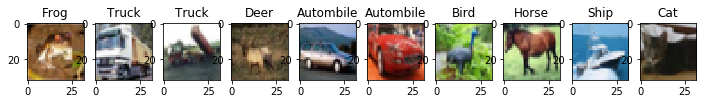

In [3]:
fig, ax = plt.subplots(1, 10, figsize = (12, 12))
for i in range(10): 
    ax[i].imshow(train_data[i])
    # this maps the train_labels to the respective words from the dictionary
    ax[i].set_title(label_to_word[train_labels[i]], fontsize = 12)

### 1.5 Create dataset and iterator

**The dataset:**

In [4]:
# reset the graph
tf.reset_default_graph()

# create training and validation data
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))

# define batch sizes
train_batch_size = 200
valid_batch_size = 5000
train_dataset = train_dataset.batch(train_batch_size)
valid_dataset = valid_dataset.batch(valid_batch_size)

# shuffle it
train_dataset = train_dataset.shuffle(buffer_size = len(train_data), reshuffle_each_iteration = True)

**The Iterator:**

In [5]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)

# method to always get the next element iterated upon
next_batch = iterator.get_next()

# init & load the data to the iterator
train_init_op = iterator.make_initializer(train_dataset)
valid_init_op = iterator.make_initializer(valid_dataset)

# get the next batch
input_data = next_batch[0]
labels = next_batch[1]

input_data = tf.cast(input_data, "float32")
onehot     = tf.one_hot(labels, 10)

## 2 Building the model

### 2.1 Data formatting & Layers

In [6]:
# kernels == weights
# the scopes' naming should be descriptive enough
with tf.variable_scope("conv_layer_1"):
    kernel_size = 5
    stride      = 1
    n_kernels   = 16
    channels    = 3
    padding     = "SAME"
    
    kernels = tf.Variable(tf.truncated_normal([kernel_size,
                                               kernel_size,
                                               channels,
                                               n_kernels],
                                              stddev = 0.1))
    biases  = tf.Variable(tf.zeros([n_kernels]))
    convolution = tf.nn.conv2d(input_data,
                               kernels,
                               strides = [1, stride, stride, 1],
                               padding = padding)
    feature_maps = tf.tanh(convolution + biases)
    
    tf.summary.histogram("con_layer1_weights", kernels)
    tf.summary.histogram("con_layer1_biases", biases)



with tf.variable_scope("pool_layer_1"):
    kernel_size = 2
    stride      = 2
    
    pooling = tf.nn.max_pool(feature_maps,
                             ksize = [1, kernel_size, kernel_size, 1],
                             strides = [1, stride, stride, 1],
                             padding = "SAME")
    

with tf.variable_scope("conv_layer_2"):
    kernel_size = 3
    stride      = 1
    n_kernels   = 32
    channels    = 16
    padding     = "SAME"
    
    kernels = tf.Variable(tf.truncated_normal([kernel_size,
                                               kernel_size,
                                               channels,
                                               n_kernels],
                                              stddev = 0.1))
    biases  = tf.Variable(tf.zeros([n_kernels]))
    convolution = tf.nn.conv2d(pooling,
                               kernels,
                               strides = [1, stride, stride, 1],
                               padding = padding)
    feature_maps = tf.tanh(convolution + biases)
    
    tf.summary.histogram("con_layer2_weights", kernels)
    tf.summary.histogram("con_layer2_biases", biases)



with tf.variable_scope("pool_layer_2"):
    kernel_size = 2
    stride      = 2
    
    pooling = tf.nn.max_pool(feature_maps,
                             ksize = [1, kernel_size, kernel_size, 1],
                             strides = [1, stride, stride, 1],
                             padding = "SAME")
    

with tf.variable_scope("full_layer_1"):
    n_neurons = 512
    
    # flatten the output; this preserves batch size;
    # with only tf.contrib.layers.fully_connected() it returns length 12800
    flat_pool = tf.contrib.layers.flatten(pooling)
    
    fully_1 = tf.contrib.layers.fully_connected(flat_pool,
                                                n_neurons,
                                                activation_fn = tf.tanh)
    
with tf.variable_scope("full_layer_2"):
    n_neurons = 10
    
    # preserve the logits for the cross entropy function...
    logits  = tf.contrib.layers.fully_connected(fully_1,
                                                n_neurons,
                                                activation_fn = None)
    
    # ...and activate afterwards
    fully_2 = tf.nn.softmax(logits)

### 2.2 Loss & Accuracy

In [7]:
## define loss...
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = onehot)

loss = tf.reduce_mean(cross_entropy)


## ...and accuracy
predict = tf.argmax(fully_2, axis = 1)
labels  = tf.cast(labels, tf.int64)

is_equal = tf.equal(predict, labels)
is_equal = tf.cast(is_equal, tf.float32)

accuracy = tf.reduce_mean(is_equal)

### 2.3 Optimizer

In [8]:
lrate = 1e-4

training_step = tf.train.AdamOptimizer(lrate).minimize(loss)

### Summaries

In [9]:
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

# merge ALL the summaries!
merged_summaries = tf.summary.merge_all()

# define filewriters
train_writer = tf.summary.FileWriter('./summaries/train/')
valid_writer = tf.summary.FileWriter('./summaries/validation/', flush_secs = .5)

## 3 Training

### 3.1 Training, Validation

In [10]:
epochs = 5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_step = 0
    
    ### define epoch loop
    for epoch in range(epochs):
        print(epoch)
        sess.run(train_init_op)
        
        ### Training
        while True:
            try:
                _, loss_value = sess.run((training_step, loss))
                # print("Training loss: {}".format(loss_value))
                _, summary  = sess.run((training_step, merged_summaries))
                train_writer.add_summary(summary, global_step)
                
                #### increment step number
                global_step += 1
                
            except tf.errors.OutOfRangeError:
                break
                
        ### Validation        
        sess.run(valid_init_op)
        # loss_value = sess.run((loss))
        
        summary = sess.run((merged_summaries))
        valid_writer.add_summary(summary, global_step)
        # print("Validation loss: {}".format(loss_value), "\n")

0
1
2
3
4


In [ ]:
### 3.2 Results

You'll need an active internet connection to view the screenshot.

![Tensorboard_Screenshot](https://tobi.tadaa-data.de/Dump/anntf_hw3.png)